# TMDLs DATA EXPLORATION
<i> Ryan Treves

Under the Clean Water Act (CWA) section 303(d), states and Tribes are required to monitor water bodies in their territory, and identify water bodies for which a water quality standard has not been met. To do this, they must conduct 'assessments' of water bodies based on whether that water body attains its water quality standard for a certain type of use (e.g., swimming, fishing). Water bodies are delineated into 'assessment units' for the purposes of organizing assessments. Based on the results of the assessment, an assessment unit is assigned an Integrated Reporting (IR) category from 1-5 based on the degree of impairment of the water body. An IR category 5 determination means that a TMDL should be developed for that assessment unit, and the water is 'impaired'. (See https://drive.google.com/drive/u/0/folders/1tGpCSD-3mRBChTC1PZStt5bdRljTK1ck for more details on IR category determination).
 Every two years (reporting cycles are biennial), states must submit their list of impaired waters (including but not limited to all waters with an IR category 5 determination) as a part of their Integrated Report (IR) to the federal EPA under  sections 303(d), 305(b), and 314.

See https://www.epa.gov/wqs-tech/supplemental-module-listing-impaired-waters-and-developing-tmdls#tab-2  for more details.

### Questions:
- How many Assessment Units (AUs) exist nationwide?
- For many AUs do we have a HUC code match?
- How many use assessments nationwide, ever, have contributed to an IR5 category determination?
- How many unique assessment units have been assigned category IR5?
- Which states have had the most use assessments leading to IR5 determinations?
- Which states have had the highest rate of IR5 determinations per assessment unit?
- For what fraction of use assessments do we have an assessment date?
- What parameters have caused the most use non-attainment declarations?
- What parameters have caused the most assessment units to be categorized as IR5, irrespective of number of use non-attainment declarations?
- What uses have the highest rate of non-attainment?

Note: the dataset of AUs doesn't include Pennsylvania (see `ATTAINS_data_cleaning.ipynb` for an explanation)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Load in ATTAINS data
# Assessment Units (source: `ATTAINS_data_cleaning.ipynb`)
AUs = pd.read_csv('all_AUs.csv')
# Assessments (source: `pull_NotSupporting_assessments.R`)
assessments = pd.read_csv('all_NotSupporting_assessments.csv', dtype={'reportingCycleText': str}, parse_dates=['assessment_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
# TMDL Actions (source: `pull_actions.R`)
all_actions = pd.read_csv('all_actions.csv', parse_dates=['completionDate', 'TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).drop_duplicates()
all_actions_permit_data = pd.read_csv('all_actions_permit_data.csv').drop('Unnamed: 0', axis=1).drop_duplicates()

# RAD Data
# HUC AUID link table (source: `get_huc_AUID_links.R`)
HUC_AUID_links = pd.read_csv('huc_AUID_links.csv', dtype={'attributes.huc12': object})
HUC_AUID_links = HUC_AUID_links.drop('Unnamed: 0', axis=1).rename(columns={'attributes.huc12': 'HUC-12', 'attributes.assessmentunitidentifier':'AUID'})
# HUC NPDES permit link table (source: `get_huc_npdes_permit_links.R`)
HUC_npdes_permit_links = pd.read_csv('huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object})
HUC_npdes_permit_links = HUC_npdes_permit_links.drop('Unnamed: 0', axis=1).rename(columns={'attributes.WBD_HUC12': 'HUC-12'})

# 1.  Assessment Units

In [4]:
AUs.rename(columns={'assessmentUnitIdentifier': 'AUID'}, inplace=True)
AUs.head()

,Unnamed: 0,AUID,assessmentUnitName,locationDescriptionText,agencyCode,stateCode,statusIndicator,waterTypeCode,waterSizeNumber,unitsCode,useClass.useClassCode,useClass.useClassName
0,1,AL03140106-0507-100,Styx River,from Perdido River to Hollinger Creek,S,AL,A,STREAM,18.52,Miles,156.0,F&W
1,2,AL03150105-0502-100,Mills Creek,from Chattooga River to Alabama-Georgia state ...,S,AL,A,STREAM,21.59,Miles,156.0,F&W
2,3,AL03150201-0308-100,Catoma Creek,from Ramer Creek to its source,S,AL,A,STREAM,21.50,Miles,156.0,F&W
3,4,AL03160112-0106-111,Valley Creek (Bankhead Lake),from Black Warrior River to end of embayment,S,AL,A,RESERVOIR EMBAYMENT,119.67,Acres,1023.0,PWS/S/F&W
4,5,AL03140104-0104-200,Boggy Hollow Creek,from Alabama-Florida state line to its source,S,AL,A,STREAM,7.45,Miles,156.0,F&W


### How many Assessment Units (AUs) have ever existed nationwide?

In [5]:
len(AUs.drop_duplicates('AUID'))

547965

### How many AUIDs do we have in our HUC-AUID link table?
Note: the HUC-AUID link table contains AUIDs in use as of 2020

In [6]:
len(HUC_AUID_links.drop_duplicates('AUID'))

419499

### How many ATTAINS AUIDs can we link with HUC codes using the HUC-AUID link table?

In [7]:
AUs_merged = HUC_AUID_links.drop_duplicates('AUID').merge(AUs, how='inner', on='AUID')
len(AUs_merged[~pd.isna(AUs_merged['HUC-12'])])

415219

What explains the AUIDs that are in the ATTAINS AUID table but not the HUC_AUID_links table?
Based on hand-checking examples from a variety of states, it appears that the primary reasons why AUIDs appear in the AUs table but not the HUC_AUID_links table are:
- Some AUIDs were added in 2022 (e.g., AL06030005-1004-200). These AUIDs would not be present in the HUC_AUID_links table because it is current as of June 2020.
- Some AUIDs were split pre-2020 and are no longer in use (e.g., CAX9013000020021202102208, see https://www.waterboards.ca.gov/sandiego/water_issues/programs/303d_list/ref_reports/miscellaneous_changes_report.shtml). These are still reflected in the AUs table because it goes back to 2002.

What explains the AUIDs that are in the HUC_AUID_links table but not the ATTAINS AUID table?
Again, based on hand-checking examples, it appears that almost all (if not all) of the AUIDs that appear in the HUC_AUID_links table but not the AUs table are from Pennsylvania, which was excluded from the AUs table due to computation limitations.

### Does a single water body ever have more than one AUID on record?

In [8]:
AUs.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
counts = AUs.groupby(['assessmentUnitName', 'locationDescriptionText'], as_index=False).nunique()
changed_AUIDs = counts[counts['AUID']>1][['assessmentUnitName', 'locationDescriptionText', 'AUID']].rename(columns={'AUID':'# unique AUIDs'})

In [10]:
changed_AUIDs = changed_AUIDs[(changed_AUIDs['assessmentUnitName'] != '<Null>') & (changed_AUIDs['locationDescriptionText'] != '<Null>')]
len(changed_AUIDs)

21750

In [11]:
changed_AUIDs = changed_AUIDs.merge(AUs[['AUID', 'assessmentUnitName', 'locationDescriptionText', 'stateCode']], on=['assessmentUnitName', 'locationDescriptionText'], how='left').drop_duplicates()
changed_AUIDs.head(20)

,assessmentUnitName,locationDescriptionText,# unique AUIDs,AUID,stateCode
0,"Middle Fork, White R.",HUC: 11010001,2,AR_11010001_026,AR
1,"Middle Fork, White R.",HUC: 11010001,2,AR-4K-11010001-026,AR
2,31 Hollow (Right Fork/Beech Fork),Entire length,2,WVBST-70-AA-1_00,WV
3,31 Hollow (Right Fork/Beech Fork),Entire length,2,WV-BST-98-BO-1_01,WV
4,ABENAKI,Abenaki,2,VT14-03L03_02,VT
5,ABENAKI,Abenaki,2,VT14-03L03_01,VT
6,ABNER CREEK,HUC: 05120201,2,INW01D3_T1013,IN
7,ABNER CREEK,HUC: 05120201,2,INW01D3_T1012,IN
8,ABNER CREEK - UNNAMED TRIBUTARY,HUC: 05120201,3,INW01D3_T1016,IN
9,ABNER CREEK - UNNAMED TRIBUTARY,HUC: 05120201,3,INW01D3_T1015,IN


Cross-referencing these records with the assessments file below, it appears that many of the examples in the table above represent water bodies in Virginia that underwent a AUID change in 2018 from using the 'VAC' prefix to using 'VAP' or 'VAW' (maybe this has to do with a change to the state's segmentation methodology?). Similar renamings may have occurred in CT, RI, MD, and MO.
Other examples seem to be distinct water bodies that happen to share the same `items.assessmentUnits.assessmentUnitName` and `items.assessmentUnits.assessmentUnitIdentifier` values - in some cases, because they are unnamed tributaries or unsegmented portions of watersheds, in other cases, because names are not specific. This appears to be the case for the examples from Alabama.
Some examples from Vermont use a two-digit 'Assessment Database segment code' suffix for "EPA tracking purposes" (e.g., VT17-01L01_01 and VT17-01L01_02, see https://www.epa.gov/sites/default/files/2019-02/documents/2018-vt-303d-list-report.pdf)

# 2. Assessments

In [12]:
assessments.head()

,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,assessmentUnitIdentifier,useName,useAttainmentCode,epaIRCategory,associatedActionIdentifier,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,CWA303dPriorityRankingText,assessment_date
0,1,AL,21AWIC,State,2004,AL-Gulf of Mexico,Contact Recreation,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaN,NaT
1,2,AL,21AWIC,State,2004,AL-Gulf of Mexico,Contact Recreation,N,NaN,NaN,N,Cause,METALS,2004.0,2002,NaN,NaN,NaT
2,3,AL,21AWIC,State,2004,AL-Gulf of Mexico,Fishing,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaN,NaT
3,4,AL,21AWIC,State,2004,AL-Gulf of Mexico,Fishing,N,NaN,NaN,N,Cause,METALS,2004.0,2002,NaN,NaN,NaT
4,5,AL,21AWIC,State,2004,AL-Gulf of Mexico,Propagation of Fish and Wildlife,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaN,NaT


In [13]:
len(assessments)

3962087

### How many use assessments nationwide, ever, have contributed to a 'Not Supporting' determination?
From here on, 'impaired' = received a 'Not Supporting' determination for any use. One assessment unit can be impaired by having multiple impairments - e.g., multiple chemicals (parameters) or multiple uses or both.
Here, a use assessment is uniquely identified by assessmentUnitIdentifier + useName + parameterName + reportingCycleText + assessment_date

In [14]:
assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'parameterName', 'assessment_date']).shape[0]

3700180

These numbers are different because the assessments table contains one row per use assessment x TMDL instance, and some use assessments are associated with multiple TMDLs from different years.

### What proportion of assessments have been associated with multiple TMDLs?

In [15]:
assessments.duplicated(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'parameterName', 'assessment_date']).value_counts(normalize=True)

False    0.933897
True     0.066103
dtype: float64

### What proportion of all assessment units have been associated with multiple TMDLs?

In [16]:
len(assessments[assessments.duplicated(subset=['assessmentUnitIdentifier', 'associatedActionIdentifier'])].dropna(subset='associatedActionIdentifier').drop_duplicates('assessmentUnitIdentifier'))/len(AUs['AUID'].unique())

0.1466663016798518

### How many unique assessment units have been impaired?

In [17]:
len(assessments['assessmentUnitIdentifier'].unique())

220327

### Which states have had the most use assessments leading to impairments?

In [18]:
assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText',  'parameterName', 'assessment_date'])[['state_code']].value_counts(normalize=True)

state_code
PA            0.150234
NH            0.136492
KS            0.086494
CA            0.060311
VA            0.058757
FL            0.050731
NJ            0.044149
OR            0.038464
WV            0.033960
NV            0.027238
IN            0.023402
MI            0.022558
WA            0.020315
MT            0.017347
NC            0.016953
MN            0.016642
ID            0.015848
OH            0.015624
MA            0.013889
TN            0.013097
IL            0.011950
TX            0.010830
OK            0.010767
WI            0.010637
KY            0.010067
AR            0.008469
LA            0.005191
SC            0.005005
PR            0.004974
CT            0.004762
VT            0.004591
GA            0.004164
AL            0.004143
SD            0.004060
IA            0.003506
CO            0.003327
HI            0.003304
NM            0.003030
MO            0.002970
NE            0.002884
RI            0.002796
DE            0.002289
MS            0.002076


### Which states have the highest and lowest rates of impairments per assessment unit?

In [19]:
# Get counts of assessment units in each state
AU_counts = AUs.drop_duplicates('AUID').groupby('stateCode', as_index=False).count()[['stateCode', 'AUID']].rename(columns={'AUID':'AUs'})

In [20]:
rates = pd.DataFrame(assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName',  'parameterName', 'reportingCycleText', 'assessment_date'])['state_code'].value_counts())
rates = rates.reset_index().rename(columns = {'index':'state', 'state_code':'# impairments'})
rates = rates.merge(AU_counts, left_on='state', right_on='stateCode', how='left')
rates['Impairment rate'] = rates['# impairments']/rates['AUs']

In [21]:
rates.sort_values(by='Impairment rate', ascending=False).head(10)

,state,# impairments,stateCode,AUs,Impairment rate
6,NJ,163360,NJ,958,170.521921
9,NV,100786,NV,711,141.752461
2,KS,320045,KS,2421,132.195374
3,CA,223161,CA,4068,54.857670
13,MT,64186,MT,1203,53.354946
28,PR,18403,PR,358,51.405028
33,SD,15022,SD,400,37.555000
26,LA,19206,LA,562,34.174377
17,OH,57812,OH,1723,33.553105
5,FL,187714,FL,7067,26.562049


In [22]:
rates.sort_values(by='Impairment rate', ascending=False).tail(10)

,state,# impairments,stateCode,AUs,Impairment rate
45,ME,6989,ME,1967,3.553127
34,IA,12973,IA,4924,2.634647
0,PA,555891,PA,216735,2.564842
38,MO,10988,MO,4331,2.537058
39,NE,10671,NE,4269,2.499649
15,MN,61579,MN,28213,2.182646
8,WV,125659,WV,60450,2.078726
49,ND,2294,ND,1834,1.250818
23,WI,39357,WI,35583,1.106062
51,NY,1548,NY,4873,0.317669


Note: this table counts an impairment as a unique combination of a parameter x use x AUID x reportingCycle. Thus, having one parameter lead to 5 uses being impaired will have the same effect on impairment rate as 5 parameters each leading to one use being impaired.

### For what fraction of use assessments do we have an assessment date?

In [23]:
use_assessments_unique = assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'parameterName', 'reportingCycleText', 'assessment_date'])
use_assessments_unique[~pd.isna(use_assessments_unique['assessment_date'])].shape[0]/use_assessments_unique.shape[0]

0.24966055705398116

### What parameters have caused the most impairments?

In [24]:
use_assessments_unique[use_assessments_unique['parameterStatusName']=='Cause']['parameterName'].value_counts(normalize=True).iloc[0:10]

ESCHERICHIA COLI (E. COLI)          0.066456
PATHOGENS                           0.065500
SILTATION                           0.060735
FECAL COLIFORM                      0.051015
DISSOLVED OXYGEN                    0.046292
PH                                  0.042408
MERCURY                             0.041188
MERCURY IN FISH TISSUE              0.036908
PCBS IN FISH TISSUE                 0.030885
POLYCHLORINATED BIPHENYLS (PCBS)    0.026713
Name: parameterName, dtype: float64

### What parameters have caused the most assessment units to be impaired, irrespective of number of use non-attainment declarations?

In [25]:
culprits_unique = assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'reportingCycleText', 'assessment_date', 'parameterName'])

culprits_unique[culprits_unique['parameterStatusName']=='Cause']['parameterName'].value_counts(normalize=True).iloc[0:10]

PATHOGENS                           0.074285
SILTATION                           0.072637
ESCHERICHIA COLI (E. COLI)          0.068852
MERCURY                             0.052655
MERCURY IN FISH TISSUE              0.046430
FECAL COLIFORM                      0.042379
PH                                  0.040274
DISSOLVED OXYGEN                    0.038448
METALS                              0.034789
POLYCHLORINATED BIPHENYLS (PCBS)    0.027160
Name: parameterName, dtype: float64

### What uses have the highest rate of non-attainment?

In [26]:
use_assessments_unique['useName'].value_counts(normalize=True).iloc[0:10]

Fish Consumption              0.145041
Aquatic Life                  0.063884
Primary Contact Recreation    0.044721
Water Contact Sports          0.043433
Recreation                    0.038437
AQUATIC LIFE USE              0.036213
Warm Water Fishes             0.031534
Cold Water Fishes             0.028781
Domestic Water Supply         0.025064
Aquatic Life Integrity        0.022375
Name: useName, dtype: float64

Let's look at an example of one AUID x use x parameter combination over time:

In [27]:
assessments[(assessments['assessmentUnitIdentifier']=='AL03140106-0302-202') &
            (assessments['useName']=='Contact Recreation') &
            (assessments['parameterName']=='AMMONIA, TOTAL')].sort_values(by='reportingCycleText').drop_duplicates()

,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,assessmentUnitIdentifier,useName,useAttainmentCode,epaIRCategory,associatedActionIdentifier,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,CWA303dPriorityRankingText,assessment_date
1694,1695,AL,21AWIC,State,2006,AL03140106-0302-202,Contact Recreation,N,NaN,NaN,N,Cause,"AMMONIA, TOTAL",2006.0,2006,NaN,NaN,2006-04-01
3225,3226,AL,21AWIC,State,2008,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",2006.0,2008,2010.0,Low,2006-04-01
4861,4862,AL,21AWIC,State,2010,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2015.0,NaN,2006-04-01
6506,6507,AL,21AWIC,State,2012,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2015.0,NaN,2006-04-01
8143,8144,AL,21AWIC,State,2014,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2016.0,NaN,2006-04-01


Clearly, the fields `cycle_first_listed` and `cycleLastAssessedText` are misleading.

### Which states have the most and fewest reporting cycles present in ATTAINS?

In [28]:
state_reporting_cycles = assessments.groupby('state_code').nunique()[['reportingCycleText']].sort_values('reportingCycleText', ascending=False)

state_reporting_cycles.head(15)

,reportingCycleText
state_code,
LA,11
NM,11
VI,11
VA,11
MS,11
CT,11
TX,11
OK,11
TN,11


In [29]:
state_reporting_cycles.tail(10)

,reportingCycleText
state_code,
OH,8
IL,8
WI,7
AR,6
MD,5
FL,4
PA,4
OR,3
WA,2


### How many assessment units have been de-listed?

In [30]:
# Determine last reporting cycle in which an AUID appears
last_cycles = assessments.groupby(['assessmentUnitIdentifier', 'parameterName'], as_index=False).max()[
        ['state_code', 'assessmentUnitIdentifier', 'parameterName', 'reportingCycleText']]
last_cycles.rename(columns={'reportingCycleText': 'last_cycle_appearing'}, inplace=True)

# Find most recent cycle for each state
most_recent_state_cycles = assessments.groupby(['state_code'], as_index=False).max()[
        ['state_code', 'reportingCycleText']]
most_recent_state_cycles.rename(columns={'reportingCycleText': 'most_recent_state_cycle'}, inplace=True)

# Merge
last_cycles = last_cycles.merge(most_recent_state_cycles, on='state_code', how='inner')
last_cycles.head()

,state_code,assessmentUnitIdentifier,parameterName,last_cycle_appearing,most_recent_state_cycle
0,HI,3-3-03,ENTEROCOCCUS,2022,2022
1,HI,HI-2-1-19_01,TURBIDITY,2002,2022
2,HI,HI-3-2-11_01,FLOW ALTERATION(S),2002,2022
3,HI,HI-3-2-11_01,NON-NATIVE FISH/SHELLFISH/ZOOPLANKTON,2002,2022
4,HI,HI-3-2-11_02,FLOW ALTERATION(S),2002,2022


In [31]:
last_cycles['delisted'] = last_cycles['last_cycle_appearing'] != last_cycles['most_recent_state_cycle']
last_cycles['delisted'].value_counts(normalize=True)

False    0.743641
True     0.256359
Name: delisted, dtype: float64

### What is the distribution of times when an AUID first appears on a 303(d) list in ATTAINS?

In [32]:
# Determine first appearance on a 303(d) list in ATTAINS
appearance_dates = assessments.groupby(['assessmentUnitIdentifier', 'parameterName'], as_index=False).min()[
        ['assessmentUnitIdentifier', 'parameterName', 'reportingCycleText']]
appearance_dates.rename(columns={'reportingCycleText': 'appearance_date'},
                               inplace=True)
appearance_dates['appearance_date'] = pd.to_datetime(appearance_dates['appearance_date']).dt.year

In [33]:
test = assessments.merge(appearance_dates, on=['assessmentUnitIdentifier', 'parameterName'], how='inner')
test.head()

,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,assessmentUnitIdentifier,useName,useAttainmentCode,epaIRCategory,associatedActionIdentifier,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,CWA303dPriorityRankingText,assessment_date,appearance_date
0,1,AL,21AWIC,State,2004,AL-Gulf of Mexico,Contact Recreation,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaN,NaT,2004
1,3,AL,21AWIC,State,2004,AL-Gulf of Mexico,Fishing,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaN,NaT,2004
2,5,AL,21AWIC,State,2004,AL-Gulf of Mexico,Propagation of Fish and Wildlife,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaN,NaT,2004
3,7,AL,21AWIC,State,2004,AL-Gulf of Mexico,Shellfishing,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaN,NaT,2004
4,9,AL,21AWIC,State,2004,AL-Gulf of Mexico,Industrial and Agriculture Uses,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaN,NaT,2004


TODO: change `appearance_date` from january 1st to just the year

### What proportion of assessments include a priority ranking? How does that proportion change over time and among states?

In [34]:
test = assessments.groupby('reportingCycleText').agg(priority_ranked_proportion=pd.NamedAgg(column='CWA303dPriorityRankingText', aggfunc=lambda x: sum(~pd.isna(x))/len(x)))
test

,priority_ranked_proportion
reportingCycleText,
2002,0.000000
2004,0.000000
2006,0.119937
2008,0.215302
2010,0.197652
2012,0.284739
2014,0.449638
2016,0.240629
2018,0.372764


In [35]:
test = assessments.groupby('state_code').agg(priority_ranked_proportion=pd.NamedAgg(column='CWA303dPriorityRankingText', aggfunc=lambda x: sum(~pd.isna(x))/len(x)))
test

,priority_ranked_proportion
state_code,
AK,0.034810
AL,0.203891
AR,0.618765
AZ,0.271879
CA,0.000000
CO,0.384391
CT,0.817600
DE,0.183097
FL,0.503222


It appears that priority ranking increased gradually over time, and is variable across states. Interestingly, California, Georgia and Rhode Island seem to not use priority rankings. According to the CA waterboards website, CA uses a different approach, instead formulating a 'completion schedule' with more urgent water bodies listed for earlier TMDLs (https://www.waterboards.ca.gov/board_decisions/adopted_orders/resolutions/2015/020315_8_amendment_clean_version.pdf p. 16). The same alternative approach appears to be used by Rhode Island (https://dem.ri.gov/sites/g/files/xkgbur861/files/programs/benviron/water/quality/pdf/calm14.pdf).

# 3. Actions

### How many unique TMDL actions do we have?

In [36]:
len(all_actions.drop_duplicates(subset='actionIdentifier'))

20009

How does this compare to the number of unique actions in our assessments table?

In [37]:
len(assessments.drop_duplicates(subset='associatedActionIdentifier'))

21835

### How many unique AUs are represented in the actions data?

In [38]:
len(all_actions.drop_duplicates(subset='assessmentUnitIdentifier'))

96171

### How many TMDL actions are there for the different pollutant types?

In [39]:
all_actions.drop_duplicates('actionIdentifier')['pollutantSourceTypeCode'].value_counts()

Both               13115
Nonpoint source     5404
Point source         982
Unknown              508
Name: pollutantSourceTypeCode, dtype: int64

### Which states have the most TMDL actions?

In [40]:
all_actions.drop_duplicates(subset='actionIdentifier')['state_code'].value_counts(normalize=True).iloc[0:10]

WV    0.268479
KS    0.101804
VA    0.088460
MD    0.042031
MT    0.028787
DE    0.028237
CO    0.022990
OK    0.021290
FL    0.020241
CA    0.019791
Name: state_code, dtype: float64

### Which states have the highest and lowest rates of TMDL actions per AUID?

In [41]:
TMDL_rates = pd.DataFrame(all_actions.drop_duplicates(
    subset=['actionIdentifier'])['state_code'].value_counts())
TMDL_rates = TMDL_rates.reset_index().rename(columns={'index': 'state', 'state_code': '# TMDLs'})
TMDL_rates = TMDL_rates[TMDL_rates['state'] != 'GU']
TMDL_rates = TMDL_rates.merge(AU_counts, left_on='state', right_on='stateCode', how='left')
TMDL_rates['TMDL rate'] = TMDL_rates['# TMDLs'] / TMDL_rates['AUs']
TMDL_rates.sort_values(by='TMDL rate', ascending=False).head(10)

,state,# TMDLs,stateCode,AUs,TMDL rate
5,DE,565,DE,590,0.957627
13,SD,369,SD,400,0.922500
3,MD,841,MD,971,0.866117
1,KS,2037,KS,2421,0.841388
11,LA,395,LA,562,0.702847
24,WY,183,WY,314,0.582803
4,MT,576,MT,1203,0.478803
12,MS,374,MS,1178,0.317487
18,NJ,304,NJ,958,0.317328
6,CO,460,CO,1893,0.243001


In [42]:
TMDL_rates.sort_values(by='TMDL rate', ascending=False).tail(10)

,state,# TMDLs,stateCode,AUs,TMDL rate
37,MI,115,MI,8028,0.014325
15,MN,344,MN,28213,0.012193
46,KY,52,KY,6239,0.008335
21,NH,200,NH,32484,0.006157
35,WA,121,WA,20272,0.005969
41,IN,94,IN,16761,0.005608
43,NC,75,NC,13628,0.005503
42,WI,83,WI,35583,0.002333
14,PA,367,PA,216735,0.001693
51,OR,5,OR,7316,0.000683


### What is the temporal distribution of TMDLs?

Based on a document here: https://www.exchangenetwork.net/schema/ATTAINS/1/ATTAINS_DET_v1.0a.xlsx , `completionDate` refers to the planned TMDL date, and `TMDLDate` refers to the actual date the TMDL was approved by EPA.

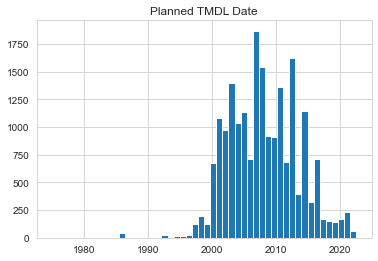

In [43]:
plt.title('Planned TMDL Date')
plt.hist(all_actions.drop_duplicates(subset='actionIdentifier')['completionDate'], bins=50);

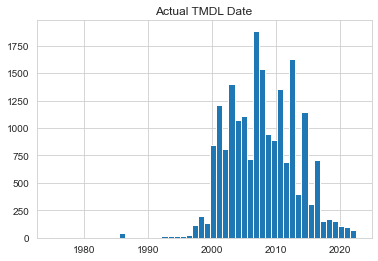

In [44]:
plt.title('Actual TMDL Date')
plt.hist(all_actions.drop_duplicates(subset='actionIdentifier')['TMDLDate'], bins=50);

Text(0.5, 0, 'Days')

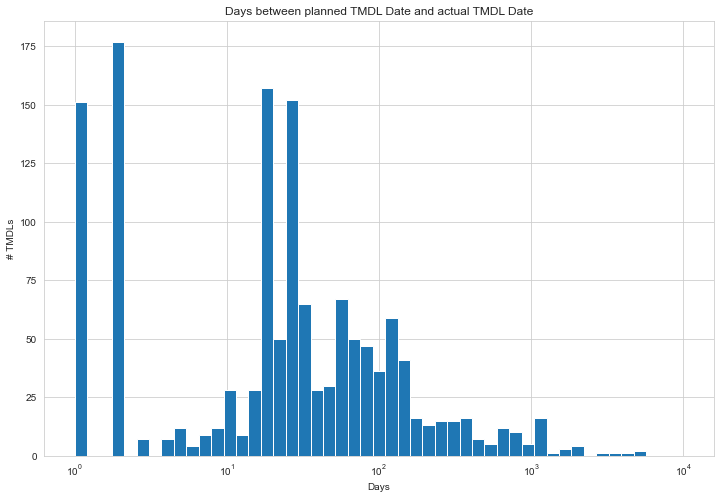

In [45]:
import numpy as np
delays = (all_actions.drop_duplicates(subset='actionIdentifier')['TMDLDate'] -
          all_actions.drop_duplicates(subset='actionIdentifier')['completionDate']) / dt.timedelta(
    days=1)
plt.figure(figsize=(12, 8))
plt.xscale("log")
plt.hist(delays, bins=np.logspace(np.log10(1),np.log10(10000.0), 50))
plt.title('Days between planned TMDL Date and actual TMDL Date')
plt.ylabel('# TMDLs')
plt.xlabel('Days')

### Which pollutants most often lead to TMDLs?

In [46]:
all_actions.drop_duplicates(subset=['actionIdentifier', 'pollutantName'])['pollutantName'].value_counts(normalize=True).iloc[0:10]

FECAL COLIFORM                  0.155362
IRON                            0.102766
ESCHERICHIA COLI (E. COLI)      0.070738
PHOSPHORUS, TOTAL               0.059801
SEDIMENT                        0.040726
PH                              0.037441
ALUMINUM                        0.036657
NITROGEN, TOTAL                 0.030498
TOTAL SUSPENDED SOLIDS (TSS)    0.027586
MANGANESE                       0.027474
Name: pollutantName, dtype: float64

### Which combinations of state x pollutant are most frequent across all TMDLS?

In [47]:
pd.DataFrame(all_actions.drop_duplicates(subset=['actionIdentifier', 'pollutantName'])[['pollutantName', 'state_code']].value_counts(normalize=True).iloc[0:10])

0
pollutantName              state_code          
IRON                       WV          0.085558
FECAL COLIFORM             WV          0.050021
ALUMINUM                   WV          0.022061
PH                         WV          0.019411
ESCHERICHIA COLI (E. COLI) VA          0.017545
FECAL COLIFORM             VA          0.015902
                           KS          0.015454
MANGANESE                  WV          0.015118
DISSOLVED OXYGEN           KS          0.009705
SEDIMENT                   MT          0.009482

### What is the time delay between a water body appearing on the 303(d) list and receiving a TMDL?
Let's try to answer this question for a few states first before looking at the whole country.

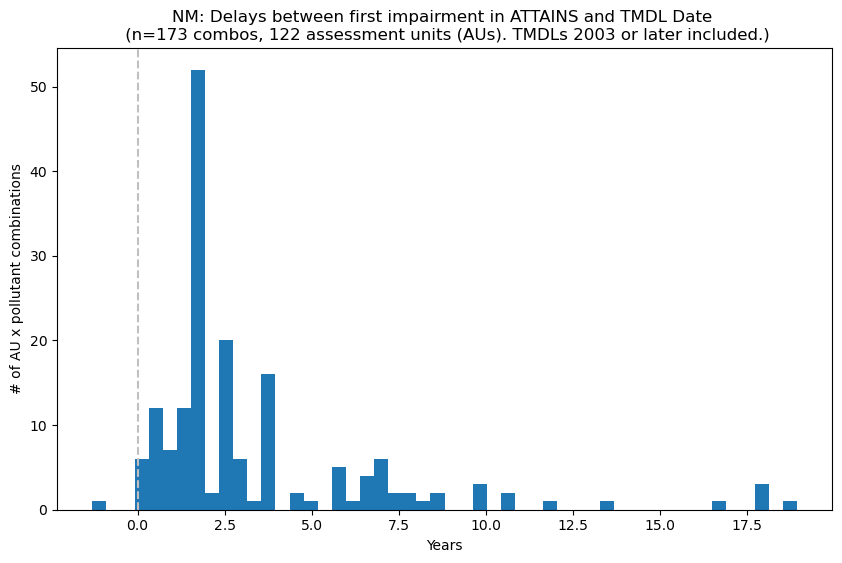

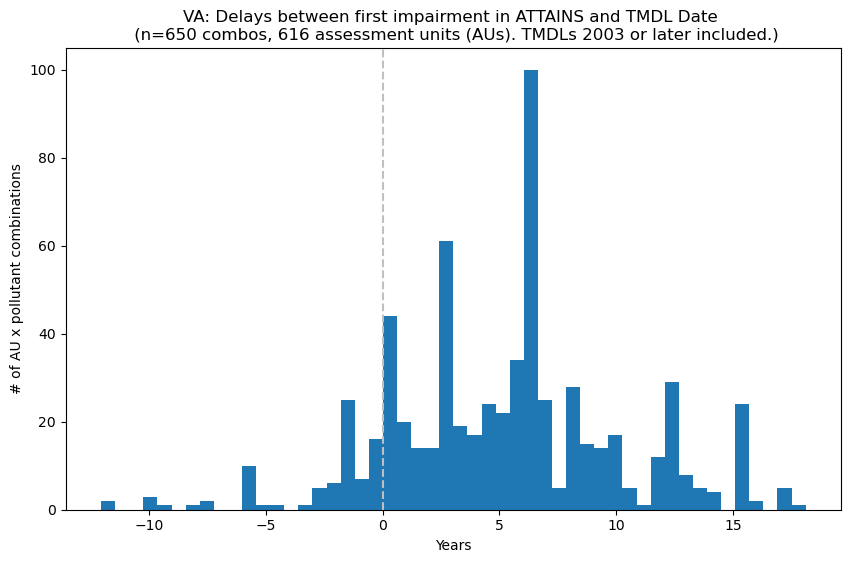

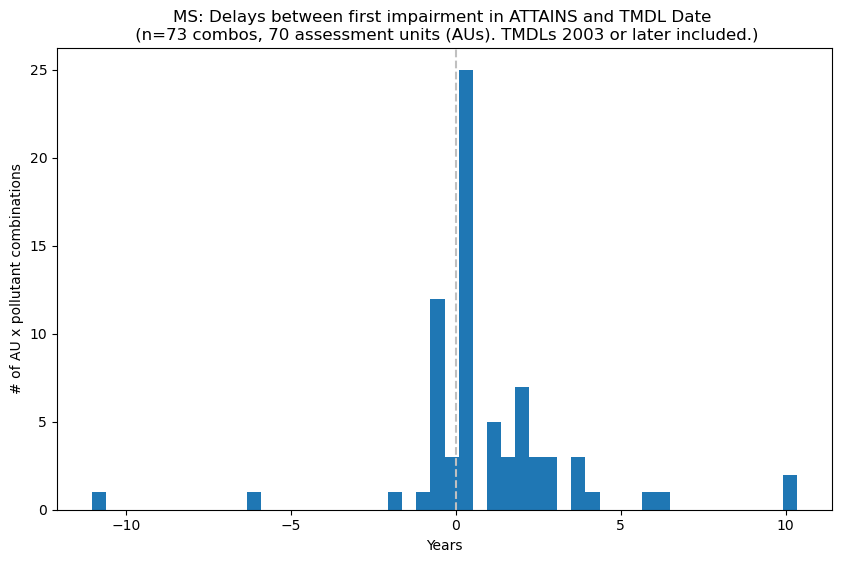

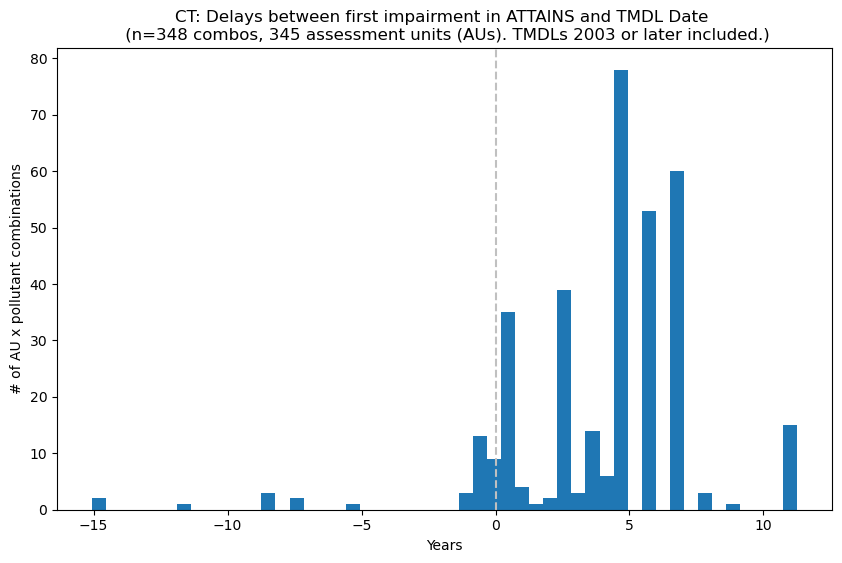

In [48]:
# These states were selected based on having a high number of unique reporting cycles present in their assessments table
plt.style.use('default')
states = ['NM', 'VA', 'MS', 'CT']
for state in states:
    state_actions = all_actions[(all_actions['state_code'] == state) & (all_actions['TMDLDate']>=pd.to_datetime('2003-01-01'))].dropna(subset=['assessmentUnitIdentifier', 'pollutantName'])
    state_assessments = assessments[assessments['state_code'] == state].dropna(
        subset=['assessmentUnitIdentifier', 'parameterName'])

    # Data cleaning to account for changes in parameter categorization over time
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(lambda x: x.replace('SULFATES', 'SULFATE'))
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(
        lambda x: x.replace('TEMPERATURE, WATER', 'TEMPERATURE'))
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(
        lambda x: x.replace('ESCHERICHIA COLI (E. COLI)', 'PATHOGENS'))
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(
        lambda x: x.replace('FECAL COLIFORM', 'PATHOGENS'))
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(
        lambda x: x.replace('ENTEROCOCCUS BACTERIA', 'ENTEROCOCCUS'))
    state_actions['pollutantName'] = state_actions['pollutantName'].apply(
        lambda x: x.replace('FECAL COLIFORM', 'PATHOGENS'))
    state_actions['pollutantName'] = state_actions['pollutantName'].apply(
        lambda x: x.replace('ESCHERICHIA COLI (E. COLI)', 'PATHOGENS'))

    # Determine first appearance on a 303(d) list in ATTAINS
    appearance_dates = state_assessments.groupby(['assessmentUnitIdentifier', 'parameterName'], as_index=False).min()[
        ['assessmentUnitIdentifier', 'parameterName', 'reportingCycleText']]
    appearance_dates.rename(columns={'reportingCycleText': 'appearance_date', 'parameterName': 'pollutantName'},
                               inplace=True)
    appearance_dates['appearance_date'] = pd.to_datetime(appearance_dates['appearance_date'])

    # Merge on AU and pollutant
    merged = state_actions.merge(appearance_dates, on=['assessmentUnitIdentifier', 'pollutantName'], how='inner')

    # Calculate delay time
    delays = (merged.drop_duplicates(subset=['assessmentUnitIdentifier', 'pollutantName'])['TMDLDate'] - merged.drop_duplicates(subset=['assessmentUnitIdentifier', 'pollutantName'])[
              'appearance_date']) / dt.timedelta(days=365)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(delays, bins=50);
    plt.axvline(x=0, linestyle='--', c='silver')
    plt.ylabel('# of AU x pollutant combinations')
    plt.xlabel('Years')
    plt.title(state + ': Delays between first impairment in ATTAINS and TMDL Date \n (n=' + str(len(delays)) + ' combos, ' + str(len(merged['assessmentUnitIdentifier'].unique())) + ' assessment units (AUs). TMDLs 2003 or later included.)')

TODO: ### How many AUs scheduled to receive a TMDL actually received one?

# 4. Exploring the HUC-NPDES Permit ID linkage table

### How many NPDES permit IDs do we have in our HUC-permit linkage table?

In [49]:
HUC_npdes_permit_links.head()

,attributes.SOURCE_FEATUREID,HUC-12,npdes_permit_id
0,AL0000019001,060300020503,AL0000019
1,AL0000019002,060300020904,AL0000019
2,AL0000019003,060300020505,AL0000019
3,AL0000019004,060300020503,AL0000019
4,AL0000019005,060300020503,AL0000019


In [50]:
len(HUC_npdes_permit_links.drop_duplicates('npdes_permit_id'))

761542

How does this compare to the total number of active NPDES permit IDs in ICIS-NPDES?

In [51]:
all_permit_ids = pd.read_csv('all_icis_npdes_permit_ids.csv')
len(all_permit_ids.drop_duplicates('npdes_permit_id'))

823373

They are of similar order of magnitude. The difference is likely due to permits in ICIS-NPDES that were retired/terminated prior to 2016 (the date of our HUC-permit linkage table), and other permits that were created after 2016.

### What proportion of TMDLs on 2020 assessment units (see HUC-AUID link table exploration above) can we now link to NPDES permit IDs?

In [52]:
actions_current_AUs = all_actions.merge(AUs_merged[['AUID']], left_on='assessmentUnitIdentifier', right_on='AUID', how='inner')
actions_current_AUs = actions_current_AUs.merge(HUC_AUID_links, on='AUID', how='inner')
len(actions_current_AUs.drop_duplicates(subset='actionIdentifier'))

7377

In [53]:
actions_current_AUs = actions_current_AUs.merge(HUC_npdes_permit_links, on='HUC-12', how='inner')
actions_current_AUs.head()

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,assessmentUnitIdentifier,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate,AUID,HUC-12,attributes.SOURCE_FEATUREID,npdes_permit_id
0,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR107777,ALR107777
1,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AAY0,ALR10AAY0
2,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AM01,ALR10AM01
3,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AA85,ALR10AA85
4,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AN53,ALR10AN53


In [54]:
len(actions_current_AUs.drop_duplicates(subset='actionIdentifier'))

6626

In [55]:
len(actions_current_AUs.drop_duplicates(subset='AUID'))

69540

In [56]:
len(actions_current_AUs.drop_duplicates(subset='npdes_permit_id'))

260319